## Notebook setup

In [1]:
import os
import io
import warnings
import datetime
import numpy as np
import base64
import pytz
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import helper
from openbb_terminal.api import openbb
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

WARNING! Breaking changes incoming! Especially avoid using kwargs, since some of them will change.
You can try <link> branch with the latest changes.


### Header

In [2]:
try:
    theme = TerminalStyle("dark", "dark", "dark")
except:
    pass
stylesheet = widgets.html_report_stylesheet()
with open("OpenBB_reports_logo.png", "rb") as image_file:
    openbb_image_encoded = base64.b64encode(image_file.read())

user_time_zone = pytz.timezone(helper.get_user_timezone())

In [3]:
# Parameters that will be replaced when calling this notebook
symbol = ""
report_name = "economy_report"

In [4]:
author = "Diogo Sousa"
report_title = f"Economy report"
report_date = pd.Timestamp.now(tz=user_time_zone).strftime("%d %B, %Y")
report_time = pd.Timestamp.now(tz=user_time_zone).strftime("%H:%M")
report_timezone = pd.Timestamp.now(tz=user_time_zone).tzinfo
report_title, report_date, report_time, report_timezone

('Economy report',
 '09 September, 2022',
 '15:37',
 <DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>)

## Data

Overview

In [5]:
overview = openbb.economy.overview()
overview.set_index(list(overview.columns[0]), inplace=True)
futures = openbb.economy.futures()
futures.set_index(list(futures.columns[0]), inplace=True)
news = openbb.common.news("economy")
news.columns = news.columns.str.title()
news.set_index("Published", inplace=True)

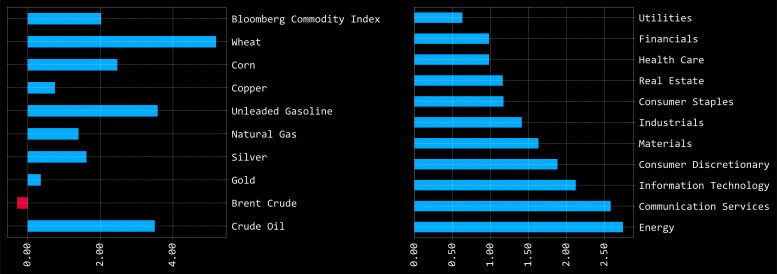

In [6]:
rtps_data = openbb.economy.rtps()
fig = plt.figure(figsize=(11, 4), constrained_layout=True)
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 1])
openbb.economy.rtps(external_axes=[ax1], chart=True)
ax1.set_title("")
ax1.set_ylabel("")

ax2 = fig.add_subplot(spec[0, 0])
chg = futures["%Chg"]
colors = [theme.up_color if x > 0 else theme.down_color for x in list(chg.values)]
ax2 = chg.plot(kind="barh", color=colors)
theme.style_primary_axis(ax2)
ax2.set_title("")
ax2.tick_params(axis="x", labelrotation=90)
ax2.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
chart_0 = f.getvalue().decode("utf-8")

Events

In [7]:
events_1, title_1 = openbb.economy.events(
    country="United states",
    start_date=datetime.datetime.now().strftime("%Y-%m-%d"),
    importance="high",
)
events_1 = events_1.set_index("Date")

events_2, title_2 = openbb.economy.events(
    country="Euro zone",
    start_date=datetime.datetime.now().strftime("%Y-%m-%d"),
    importance="all",
)
events_2 = events_2[
    (events_2["Importance"] == "High") | (events_2["Importance"] == "Medium")
]
events_2 = events_2.set_index("Date")

events_3, title_3 = openbb.economy.events(
    country="China",
    start_date=datetime.datetime.now().strftime("%Y-%m-%d"),
    importance="all",
)
events_3 = events_3.set_index("Date")

Yields

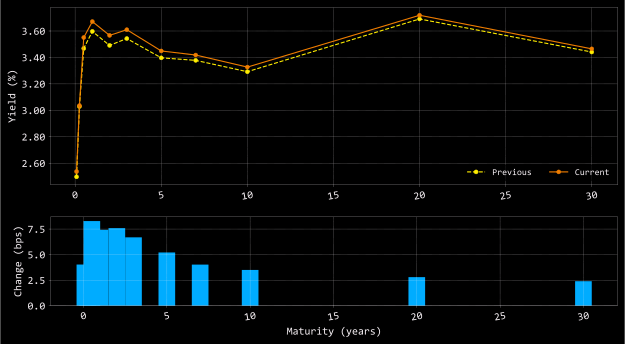

In [8]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(16 / 9 * 5, 5),
    gridspec_kw={"height_ratios": [2, 1]},
    dpi=150,
)
ycrv_country_1 = "United states"
ycrv_data_1 = openbb.economy.ycrv(country=ycrv_country_1)

openbb.economy.ycrv(country=ycrv_country_1, external_axes=[ax1, ax2], chart=True)

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ycrv_chart_1 = f.getvalue().decode("utf-8")

ycrv_data_1.set_index("Tenor", inplace=True)
ycrv_data_1.index = ["1M", "3M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y"]

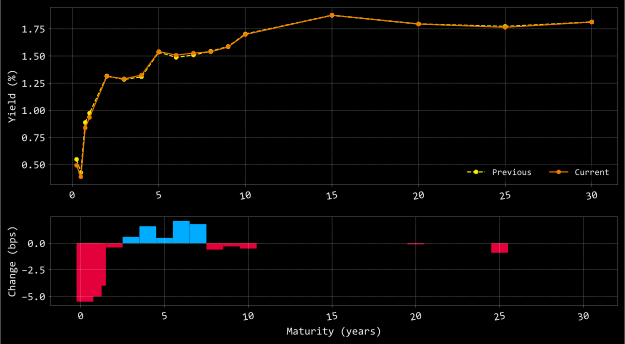

In [9]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(16 / 9 * 5, 5),
    gridspec_kw={"height_ratios": [2, 1]},
    dpi=150,
)
ycrv_country_2 = "Germany"
ycrv_data_2 = openbb.economy.ycrv(country=ycrv_country_2)

openbb.economy.ycrv(country=ycrv_country_2, external_axes=[ax1, ax2], chart=True)

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ycrv_chart_2 = f.getvalue().decode("utf-8")
ycrv_data_2.set_index("Tenor", inplace=True)
ycrv_data_2.index = ["3M", "6M", "9M", "1Y", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y", "15Y", "20Y", "25Y", "30Y"]


In [10]:
openbb.economy.treasury_maturities()

,Maturities
Instrument,
nominal,"1m, 3m, 6m, 1y, 2y, 3y, 5y, 7y, 10y, 20y, 30y"
inflation,"5y, 7y, 10y, 20y, 30y"
average,Defined by function
secondary,"4w, 3m, 6m, 1y"


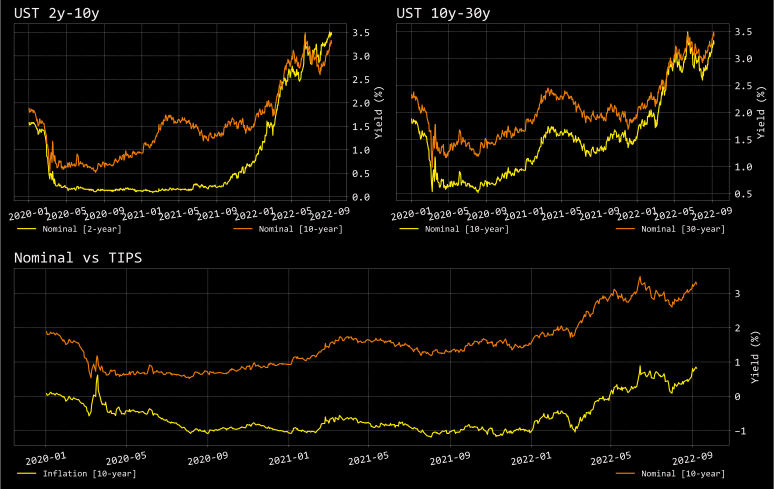

In [11]:
fig = plt.figure(figsize=(11, 7), constrained_layout=True)
spec = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(spec[0, 0])
openbb.economy.treasury(
    instruments=["nominal"],
    maturities=["2y", "10y"],
    frequency="daily",
    start_date="2020-01-01",
    external_axes=[ax1],
    chart=True,
)
ax1.set_title("UST 2y-10y", loc="left")

ax2 = fig.add_subplot(spec[0, 1])
openbb.economy.treasury(
    instruments=["nominal"],
    maturities=["10y", "30y"],
    frequency="daily",
    start_date="2020-01-01",
    external_axes=[ax2],
    chart=True,
)
ax2.set_title("UST 10y-30y", loc="left")


ax3 = fig.add_subplot(spec[1, :])
openbb.economy.treasury(
    instruments=["nominal", "inflation"],
    maturities=["10y"],
    frequency="daily",
    start_date="2020-01-01",
    external_axes=[ax3],
    chart=True,
)
ax3.set_title("Nominal vs TIPS", loc="left")

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ust = f.getvalue().decode("utf-8")

Equity Market

In [12]:
valuation = openbb.economy.valuation()
performance = openbb.economy.performance()

In [13]:
# openbb.economy.available_indices()

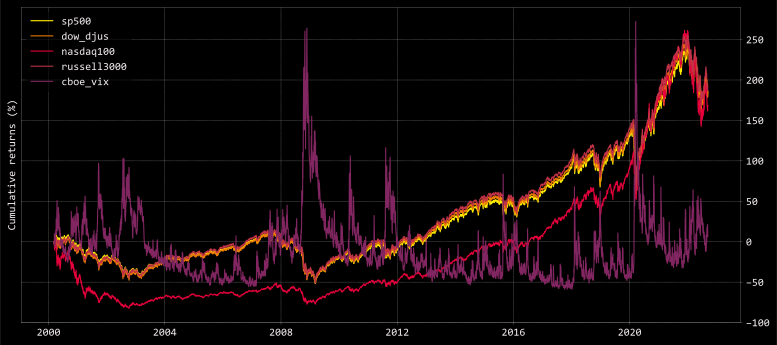

In [14]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
data = openbb.economy.index(indices=["sp500", "dow_djus", "nasdaq100", "russell3000", "cboe_vix"], start_date="2000-03-09")

data = data.pct_change().dropna()
data = (1 + data.shift(periods=1, fill_value=0)).cumprod() - 1
ax.plot(data*100)
ax.set_title("")
ax.legend(data.columns)
ax.set_ylabel('Cumulative returns (%)')

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
eqty_0 = f.getvalue().decode("utf-8")

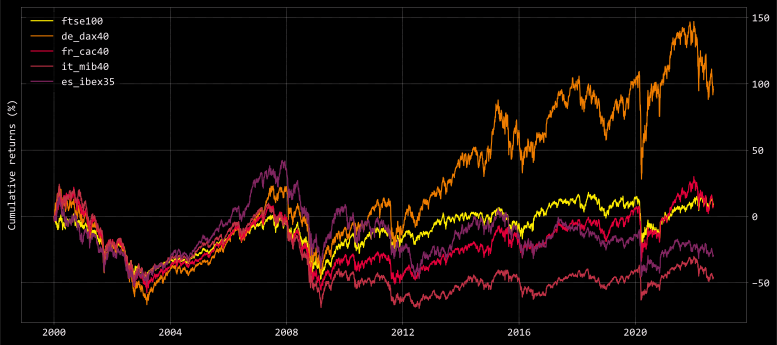

In [15]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
data = openbb.economy.index(indices=["ftse100", "de_dax40", "fr_cac40", "it_mib40", "es_ibex35"], start_date="2000-01-01")

data = data.pct_change().dropna()
data = (1 + data.shift(periods=1, fill_value=0)).cumprod() - 1
ax.plot(data*100)
ax.set_title("")
ax.legend(data.columns)
ax.set_ylabel('Cumulative returns (%)')

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
eqty_1 = f.getvalue().decode("utf-8")

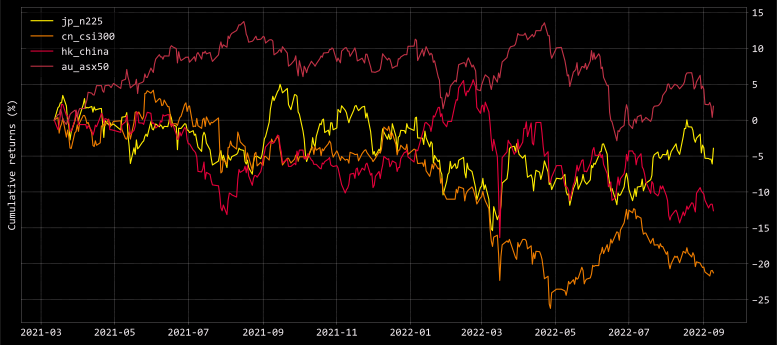

In [16]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
data = openbb.economy.index(indices=["jp_n225", "cn_csi300", "hk_china", "au_asx50"], start_date="2014-01-01")

data = data.pct_change().dropna()
data = (1 + data.shift(periods=1, fill_value=0)).cumprod() - 1
ax.plot(data*100)
ax.set_title("")
ax.legend(data.columns)
ax.set_ylabel('Cumulative returns (%)')

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
eqty_2 = f.getvalue().decode("utf-8")

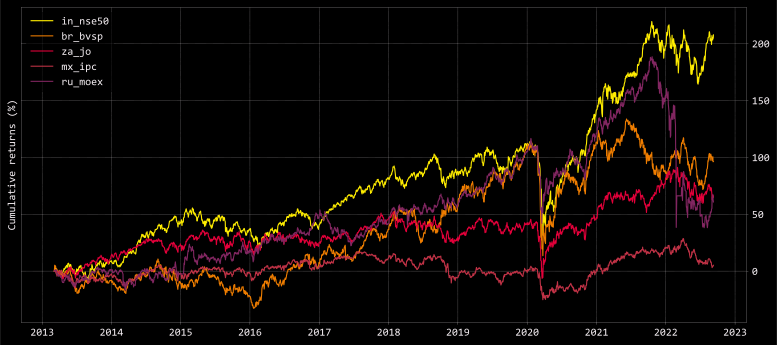

In [17]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
data = openbb.economy.index(indices=["in_nse50", "br_bvsp", "za_jo", "mx_ipc", "ru_moex"], start_date="2013-01-01")

data = data.pct_change().dropna()
data = (1 + data.shift(periods=1, fill_value=0)).cumprod() - 1
ax.plot(data*100)
ax.set_title("")
ax.legend(data.columns)
ax.set_title("")
ax.set_ylabel('Cumulative returns (%)')

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
eqty_3 = f.getvalue().decode("utf-8")

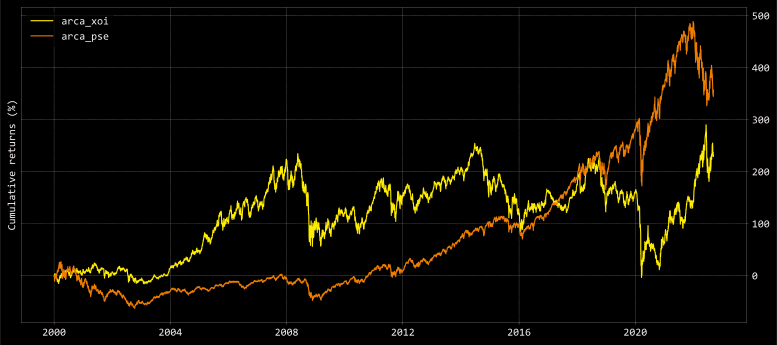

In [18]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
data = openbb.economy.index(indices=["arca_xoi", "arca_pse"], start_date="2000-01-01")

data = data.pct_change().dropna()
data = (1 + data.shift(periods=1, fill_value=0)).cumprod() - 1
ax.plot(data*100)
ax.set_title("")
ax.legend(data.columns)
ax.set_title("")
ax.set_ylabel('Cumulative returns (%)')

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
eqty_4 = f.getvalue().decode("utf-8")

Macro

In [19]:
# openbb.economy.country_codes()

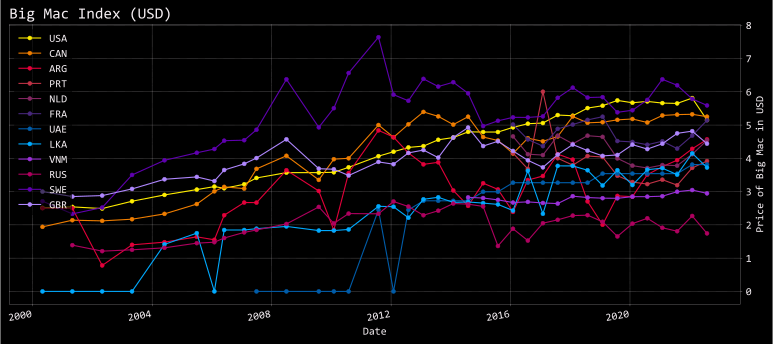

In [20]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.economy.bigmac(
    country_codes=[
        "USA",
        "CAN",
        "ARG",
        "PRT",
        "NLD",
        "FRA",
        "UAE",
        "LKA",
        "VNM",
        "RUS",
        "SWE",
        "GBR",
    ],
    external_axes=[ax],
    chart=True,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bigmac = f.getvalue().decode("utf-8")

In [21]:
# openbb.economy.macro_parameters()

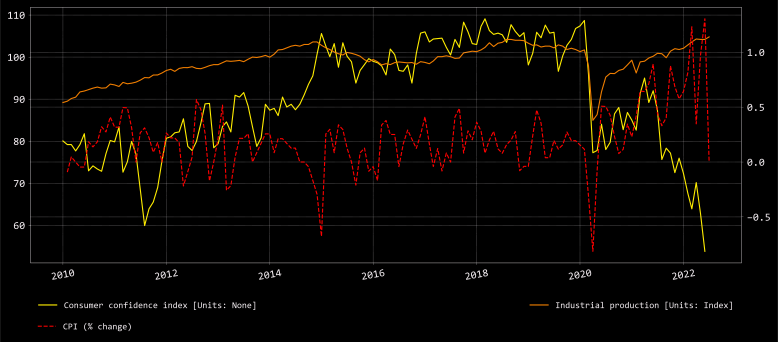

In [22]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.economy.macro(parameters=["CONF", "IP"], start_date="2010-01-01", external_axes=[ax], chart=True)
ax.set_title("")

ax1 = ax.twinx()
df, df_dict, _ = openbb.economy.macro(parameters=["CPI"], start_date="2010-01-01")
cpi_chg = df.pct_change(1)*100
ax1.plot(cpi_chg, linestyle="--", color="red")

ax1.legend(["CPI (% change)"],
            bbox_to_anchor=(0.005, 0.3, 1, -0.52),
            loc="upper left",
            borderaxespad=0,
            prop={"size": 9},
)
ax1.set_title("")

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macro_0 = f.getvalue().decode("utf-8")

In [23]:
# openbb.economy.fred_ids("gross domestic product growth")

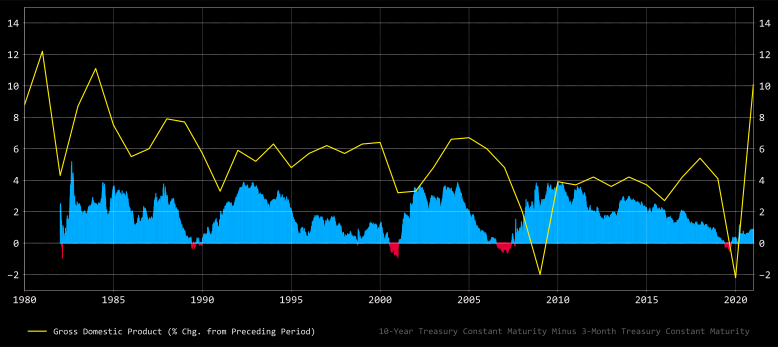

In [24]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)

df, df_dict = openbb.economy.fred_series(series_ids=["T10Y3M"], start_date="1980-01-01")
ax.plot(df, linestyle = 'None')
ax.fill_between(df.index.values, df["T10Y3M"], where=df["T10Y3M"] < 0, color=theme.down_color)
ax.fill_between(df.index.values, df["T10Y3M"], where=df["T10Y3M"] > 0, color=theme.up_color)
ax.set_ylim([-3, 15])
ax.legend([df_dict["T10Y3M"]["title"]],
            bbox_to_anchor=(0, 0.40, 1, -0.52),
            loc="upper right",
            borderaxespad=0,
            prop={"size": 9},
)
ax.set_title("")

ax1 = ax.twinx()
openbb.economy.fred_series(series_ids=["A191RP1A027NBEA"], start_date="1980-01-01", external_axes=[ax1], chart=True)
ax1.set_ylim([-3, 15])
ax1.set_title("")

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
fred_0 = f.getvalue().decode("utf-8")

## Render the report template to a file

In [27]:
body = ""

img = f'<img src="data:image/png;base64,{openbb_image_encoded.decode()}" alt="OpenBB" style="width:144px;">'
floppy_disk_img="floppy-disc.png"
body += widgets.header(
    img,
    floppy_disk_img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>ECONOMY REPORT: Leverage multiple sources to create custom reports.</b>",
)

body += widgets.tablinks(
    [
        "Overview",
        "Events",
        "Yields",
        "Equity Market",
        "Macro Data",
    ]
)

# Overview
htmlcode = widgets.row([widgets.h(3, "Global markets (source: WSJ)") + overview.to_html()])

htmlcode += widgets.row(
    [widgets.h(3, "Commodities (source: WSJ)") + futures.to_html()]
    + [
        widgets.h(3, "Real-time sector performance (source: Alphavantage)")
        + rtps_data.to_html().replace("table", 'table style="display:inline"')
    ]
)
htmlcode += widgets.row([chart_0])
htmlcode += widgets.row([widgets.h(3, "Top news on 'economy' keyword (source: Newsapi)") + news[:6].to_html()])
body += widgets.add_tab("Overview", htmlcode)

# Events
htmlcode = widgets.row([widgets.h(3, "Economic calendars (source: investing.com)")])
htmlcode += widgets.row([widgets.h(3, title_1) + events_1.to_html()])
htmlcode += widgets.row([widgets.h(3, title_2) + events_2.to_html()])
htmlcode += widgets.row([widgets.h(3, title_3) + events_3.to_html()])
body += widgets.add_tab("Events", htmlcode)

# Yields
htmlcode = widgets.row([widgets.h(3, f"{ycrv_country_1} yield curve (source: investing.com)") + ycrv_chart_1])
htmlcode += widgets.row([widgets.h(3, "") + ycrv_data_1.to_html()])

htmlcode += widgets.row([widgets.h(3, f"{ycrv_country_2} yield curve (source: investing.com)") + ycrv_chart_2])
htmlcode += widgets.row([widgets.h(3, "") + ycrv_data_2.to_html()])

htmlcode += widgets.row([widgets.h(3, "US treasuries (source: EconDB)") + ust])

body += widgets.add_tab("Yields", htmlcode)

# Equity market
htmlcode = widgets.row([widgets.h(3, "Valuation (source: Finviz)") + valuation.to_html()])
htmlcode += widgets.row([widgets.h(3, "Performance (source: Finviz)") + valuation.to_html()])
htmlcode += widgets.row([widgets.h(3, "US markets (source: YahooFinance)") + eqty_0])
htmlcode += widgets.row([widgets.h(3, "European markets (source: YahooFinance)") + eqty_1])
htmlcode += widgets.row([widgets.h(3, "APAC markets (source: YahooFinance)") + eqty_2])
htmlcode += widgets.row([widgets.h(3, "Emerging markets (source: YahooFinance)") + eqty_3])
htmlcode += widgets.row([widgets.h(3, "ARCA (source: YahooFinance)") + eqty_4])
body += widgets.add_tab("Equity Market", htmlcode)

# Macro
htmlcode = widgets.row([widgets.h(3, "Bigmac index (source: Nasdaq)") + bigmac])
htmlcode += widgets.row([widgets.h(3, "Leading indicators (source: EconDB)") + macro_0])
htmlcode += widgets.row([widgets.h(3, "Recession indicator (source: FRED)") + fred_0])
body += widgets.add_tab("Macro Data", htmlcode)

body += widgets.tab_clickable_and_save_evt()
report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)